#  Impact of Mobile Reply and New Discussion Tools

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** Last Update: 01 September 2022**

[TASK](https://phabricator.wikimedia.org/T298058) | [CODEBASE](https://gitlab.wikimedia.org/mneisler/discussiontools-on-mobile-analysis-2022)

# Table of Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Talk page comment completion rate](#Talk-page-comment-completion-rate)
4. [Talk Page Edit Revert Rate](#Talk-Page-Edit-Revert-Rate)

# Introduction

In [T282638](https://phabricator.wikimedia.org/T282638), mobile reply and new discussion tools were introduced at partner Wikipedias and the `Read as Wiki` page view enabled by default.

This task represents the work with conducting an impact analysis to evaluate what impact introducing the Reply and New Discussion Tools on mobile and setting the Read as wiki page view as the default has had on:

* Peoples' likelihood to successfully publish new talk page topics and comments they initiate using the mobile site
* Peoples' likelihood to publish edits to talk pages on mobile that are disruptive to other volunteers.

The results of this analysis will be used to determine if any adjustment are needed to the DiscussionTools before making them available to more people in the planned AB test. 

# Methodology

A pre and post deployment analysis was used to detemine any signficant changes resulting from the introduction of DiscussionTools on Mobile. We reviewed data logged two weeks before and after deployment of the DiscussionTools in [T298221](https://phabricator.wikimedia.org/T298221) on 29 June 2022. Note: Since an AB Test was not done for this analysis, some of the oberserved changes described below may be due to other variables such as seasonality effects over the observerved timeframe.

We used data logged in the following schemas to understand editing behavior on partner wikis. 
* [MobileWebUIActions](https://schema.wikimedia.org/#!/secondary/jsonschema/analytics/legacy/mobilewebuiactionstracking) to track interactions on the mobilefrontend talk overlay 
* [EditAttemptStep](https://schema.wikimedia.org/#!/secondary/jsonschema/analytics/legacy/editattemptstep) to track interactions on the Read as wiki page and usage of DiscussionTools.
* [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) to track total published mobile web edits and reverts.

Partner Wikis: jawiki, arwiki, freiki, kowiki, viwiki, hewiki, bnwiki, zhwiki, htwiki. We seeked wikis that used RTL and LTR languages, wikis whose editors bases includes significant populations of people living in East Asia and Africa, non-Latin scripts.

Other relevant phab tasks and resources:
* [Project identification](https://phabricator.wikimedia.org/T294609)
* [Ensure MobileFrontEnd Logging is in place](https://phabricator.wikimedia.org/T302108)
* [Instrumentation spec](https://docs.google.com/spreadsheets/d/1XoQtgvot_3-f9T9MWCh4nUX_hn7dDFiRacfKPpzPKT4/edit#gid=0)



In [147]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
   # Modeling 
    library(brms)
    library(lme4)
    library(tidybayes)
    set.seed(5)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Talk page comment completion rate
## Peoples' likelihood to successfully publish new talk page topics and comments they initiate using the mobile site 

Instrumentation Notes and Caveats:  
* At the time of deployment, all discussiontool related events on mobile were incorrectly tagged as desktop. A [patch](https://gerrit.wikimedia.org/r/c/mediawiki/extensions/DiscussionTools/+/824557) was submitted to fix this for future analyses. For the purpose of this analysis, I relied on the pagetoken to join EditAttemptData with MobileWebUIActions to determine mobile DT edits. 
* Not all components of the Mobile Frontend edit workflow described in https://phabricator.wikimedia.org/T302108 are currrenlty instrumented in MobileWebUIActions. Pending resolution of that task, we were limited to Read as Wiki completion rates on mobile web and just add topic button and section clicks on the mobile talk page overlay. I also looked at engagement (percent of views that lead to a click) and overall published mobile edits as a way to help more fully understand changes in interaction on mobile talk pages. 



## Mobile Read as Wiki Edit Completion Rate 

For the purpose of this analysis, I reviewed both non-DT new topic and comments on mobile using EditAttemptStep `platform = 'mobile'` pre and post deployment and relied on the pagetoken to join EditAttemptData with MobileWebUIActions to determine new topics and comments added with the mobile Discussion tools edits post deployment. These two data sets were then joined to determine the edit completion rate including both dt and non-dt edits.

Other Instrumentation Notes:
* ReadasWiki view was not presented as default on mobile prior to deployment of discussiontools. 
* EditAttemptStep can have multiple editing sessions in a given pageload

## Non-DT Edits

In [3]:
# edit completion rate on mobile (read as wiki mobile frontend edits)

query<- 
"
WITH  edit_attempts AS (
    SELECT 
     date_format(dt, 'yyyy-MM-dd') AS `date`,
     wiki AS wiki,
     event.user_id as user_id,
     event.editing_session_id as edit_attempt_id,
     event.editor_interface as editor_interface,
     event.integration as integration,
     CASE
        WHEN event.user_editcount is NULL THEN 'undefined'
        WHEN event.user_editcount  < 100 THEN 'under 100'
        WHEN (event.user_editcount  >=100 AND event.user_editcount < 500) THEN '100-499'
     ELSE '500+'
    END AS editor_experience
    FROM event.editattemptstep
    WHERE
-- only in participating wikis
   wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
-- two weeks prior and post deployments
    AND year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
  -- remove bots
    AND useragent.is_bot = false
-- review all talk namespaces
    AND event.page_ns % 2 = 1
-- only mobilefrontend
    AND event.platform = 'phone'
    AND event.action = 'init' 
    AND event.is_oversample = FALSE
),

-- find all published comments
published_comments AS (
SELECT
     event.user_id as user_id,
     event.editing_session_id AS edit_save_id,
     wiki AS wiki
     FROM event.editattemptstep
     WHERE
 -- only in participating wikis
    wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
-- two weeks prior and post deployments
    AND year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
   AND event.action = 'saveSuccess'
   AND event.page_ns % 2 = 1
   AND event.platform = 'phone'
)


-- main query
SELECT
    edit_attempts.`date`,
    edit_attempts.wiki,
    edit_attempts.user_id,
    edit_attempts.edit_attempt_id,
    edit_attempts.editor_experience,
    edit_attempts.integration,
    edit_attempts.editor_interface,
    published_comments.edit_save_id,
-- was saved in either talk page edit
    IF (published_comments.edit_save_id IS NOT NULL, 1, 0) AS edit_success
FROM edit_attempts
LEFT JOIN published_comments ON
    edit_attempts.edit_attempt_id = published_comments.edit_save_id AND
    edit_attempts.wiki = published_comments.wiki"

In [4]:
nondt_edit_attempts <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [5]:
#reformat and clean data
nondt_edit_attempts$date <- as.Date(nondt_edit_attempts$date, format = "%Y-%m-%d")


#clarfiy wiki names
nondt_edit_attempts <- nondt_edit_attempts %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'arwiki' ~ "Arabic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'htwiki' ~ 'Haitian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 


### Overall

In [6]:
# edit completion rate
edit_completes_overall_nondt <- nondt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_nondt

`summarise()` ungrouping output (override with `.groups` argument)



pre_post n_attempts n_published pct_completed
1 post     1359       462         0.3399558    
2 pre       808       180         0.2227723

### By Anon

In [7]:
# edit completion rate
edit_completes_overall_nondt_byanon <- nondt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    group_by(is_anon, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_nondt_byanon

`summarise()` regrouping output by 'is_anon' (override with `.groups` argument)



is_anon pre_post n_attempts n_published pct_completed
1 false   post     981        403         0.41080530   
2 false   pre      582        171         0.29381443   
3 true    post     378         60         0.15873016   
4 true    pre      226         10         0.04424779

### By Experience Level

In [8]:
# edit completion rate
edit_completes_overall_nondt_byexp <- nondt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    group_by(editor_experience, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_nondt_byexp

`summarise()` regrouping output by 'editor_experience' (override with `.groups` argument)



editor_experience pre_post n_attempts n_published pct_completed
1 100-499           post      79         26         0.32911392   
2 100-499           pre       30          5         0.16666667   
3 500+              post     586        300         0.51194539   
4 500+              pre      237        130         0.54852321   
5 under 100         post     694        138         0.19884726   
6 under 100         pre      541         47         0.08687616

### By Wiki

In [9]:
# edit completion rate by wiki
edit_completes_overall_nondt_bywiki <- nondt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    group_by(wiki, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_nondt_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki                 pre_post n_attempts n_published pct_completed
1  Arabic Wikipedia     post     187        33          0.1764706    
2  Arabic Wikipedia     pre      147        24          0.1632653    
3  Bengali Wikipedia    post     169        67          0.3964497    
4  Bengali Wikipedia    pre       77        30          0.3896104    
5  Chinese Wikipedia    post     136        38          0.2794118    
6  Chinese Wikipedia    pre      103        17          0.1650485    
7  French Wikipedia     post     196        87          0.4438776    
8  French Wikipedia     pre      101        23          0.2277228    
9  Hebrew Wikipedia     post     124        62          0.5000000    
10 Hebrew Wikipedia     pre       89        47          0.5280899    
11 Japanese Wikipedia   post     322        89          0.2763975    
12 Japanese Wikipedia   pre      198        27          0.1363636    
13 Korean Wikipedia     post      38        12          0.3157895    
14 Korean Wikipedia     pre       23         5          0.2173913    
15 Vietnamese Wikipedia post     187        81          0.4331551    
16 Vietnamese Wikipedia pre       70        14          0.2000000

## DT Edits

Need to account for separately as they were not tagged correctly. Note: These would only be logged post deployment following deployment of the feature to partner wikis on 29 June 2022.

In [10]:
query<- 
"
WITH mobile_views AS (

SELECT 
 date_format(dt, 'yyyy-MM-dd') AS `date`,
 wiki as wiki,
 event.pageToken AS view_page_token
FROM
event.mobilewebuiactionstracking 
WHERE
 year = 2022
AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
AND event.action = 'init'
AND event.pageNamespace % 2 == 1  -- talk page views
AND wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
),


edit_attempts AS (
    SELECT
      wiki AS wiki,
      event.user_id as user_id,
      event.page_token AS eas_page_token,
      event.editing_session_id as edit_attempt_id,
      CASE
           WHEN event.init_type = 'page' AND event.integration = 'discussiontools' THEN 'reply_tool'
           WHEN event.init_type = 'section' AND event.integration == 'discussiontools' THEN 'new_topic_tool'
          ELSE 'NA' -- check to make sure all edit types accounted for in above list
          END AS section_edit_type,
    CASE
        WHEN event.user_editcount is NULL THEN 'undefined'
        WHEN event.user_editcount  < 100 THEN 'under 100'
        WHEN (event.user_editcount  >=100 AND event.user_editcount < 500) THEN '100-499'
     ELSE '500+'
    END AS editor_experience
    FROM event.editattemptstep
    WHERE
-- only in participating wikis
   wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
-- two weeks prior and post deployments
    AND year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
  -- remove bots
    AND useragent.is_bot = false
-- review all talk namespaces
    AND event.page_ns % 2 = 1
    AND event.action = 'init' 
    AND event.is_oversample = FALSE
-- no desktop VE or wikitext events logged
    AND NOT (event.integration = 'page' AND event.editor_interface = 'wikitext')
),

-- find all published comments
published_comments AS (
SELECT
     event.user_id as user_id,
     event.editing_session_id AS edit_save_id,
     wiki AS wiki
     FROM event.editattemptstep
     WHERE
 -- only in participating wikis
    wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
    AND year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
   AND event.action = 'saveSuccess'
   AND event.page_ns % 2 = 1
)


-- main query
SELECT
    mobile_views.`date`,
    mobile_views.wiki,
    edit_attempts.user_id,
    edit_attempts.edit_attempt_id,
    edit_attempts.section_edit_type,
    edit_attempts.editor_experience,
    published_comments.edit_save_id,
-- was talk page edit attempt
   IF(edit_attempts.edit_attempt_id IS NOT NULL, 1, 0) AS edit_attempt,
-- was saved in either talk page edit
    IF (published_comments.edit_save_id IS NOT NULL, 1, 0) AS edit_success
FROM mobile_views
LEFT JOIN edit_attempts ON 
    mobile_views.view_page_token = edit_attempts.eas_page_token AND
   mobile_views.wiki = edit_attempts.wiki
LEFT JOIN published_comments ON
    edit_attempts.edit_attempt_id = published_comments.edit_save_id AND
    edit_attempts.wiki = published_comments.wiki"

In [11]:
dt_edit_attempts <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [12]:
#reformat and clean data
dt_edit_attempts$date <- as.Date(dt_edit_attempts$date, format = "%Y-%m-%d")


#clarfiy wiki names
dt_edit_attempts  <- dt_edit_attempts %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'arwiki' ~ "Arabic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'htwiki' ~ 'Haitian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 



### Overall

In [13]:
# edit completion rate
edit_completes_overall_dt <- dt_edit_attempts %>%
    filter(edit_attempt == 1)  %>%  # only review completed edit attempts
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post_dt')) %>%
    group_by(pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_dt

`summarise()` ungrouping output (override with `.groups` argument)



pre_post n_attempts n_published pct_completed
1 post_dt  1466       501         0.3417462

### By Anon

In [14]:
# edit completion rate
edit_completes_overall_dt_byanon <- dt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    group_by(is_anon, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_dt_byanon

`summarise()` regrouping output by 'is_anon' (override with `.groups` argument)



is_anon pre_post n_attempts n_published pct_completed
1 false   post     878        424         0.4829157    
2 false   pre        1          1         1.0000000    
3 true    post     589         78         0.1324278

### By Experience Level

In [15]:
# edit completion rate
edit_completes_overall_dt_byexp <- dt_edit_attempts %>%
    filter(editor_experience != 'NULL') %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    group_by(editor_experience, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_dt_byexp

`summarise()` regrouping output by 'editor_experience' (override with `.groups` argument)



editor_experience pre_post n_attempts n_published pct_completed
1 100-499           post       60        42         0.7000000    
2 500+              post      356       194         0.5449438    
3 under 100         post     1050       267         0.2542857

### By Wiki

In [16]:
# edit completion rate by wiki
edit_completes_overall_dt_bywiki <- dt_edit_attempts %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post'),
          is_anon = ifelse(user_id == 0, 'true', 'false')) %>%
    filter(pre_post != 'pre')  %>% #Dt only logged post deployment
    group_by(wiki, pre_post) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
             n_published = n_distinct(edit_save_id),
             pct_completed = n_published/n_attempts)
              
edit_completes_overall_dt_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki                 pre_post n_attempts n_published pct_completed
1 Arabic Wikipedia     post     370        111         0.3000000    
2 Bengali Wikipedia    post     142         50         0.3521127    
3 Chinese Wikipedia    post     134         44         0.3283582    
4 French Wikipedia     post     248         83         0.3346774    
5 Haitian Wikipedia    post       4          1         0.2500000    
6 Hebrew Wikipedia     post     160         84         0.5250000    
7 Japanese Wikipedia   post     234         77         0.3290598    
8 Korean Wikipedia     post      56         18         0.3214286    
9 Vietnamese Wikipedia post     127         41         0.3228346

## DT and Non DT Edit Completion Rate Combined
### Overall

In [17]:
# combine two tables

edit_completes_overall <- rbind(edit_completes_overall_dt, edit_completes_overall_nondt) 

edit_completes_overall 

pre_post n_attempts n_published pct_completed
1 post_dt  1466       501         0.3417462    
2 post     1359       462         0.3399558    
3 pre       808       180         0.2227723

In [18]:
pre_post = c('pre', 'post')
pct_completed <- c(0.22227723, 0.3408849)

edit_completes_overall_combined <- data.frame(pre_post, pct_completed)


In [19]:
# set factor levels

edit_completes_overall_combined$pre_post <-
  factor(
    edit_completes_overall_combined$pre_post,
    levels = c('pre', 'post')
  )

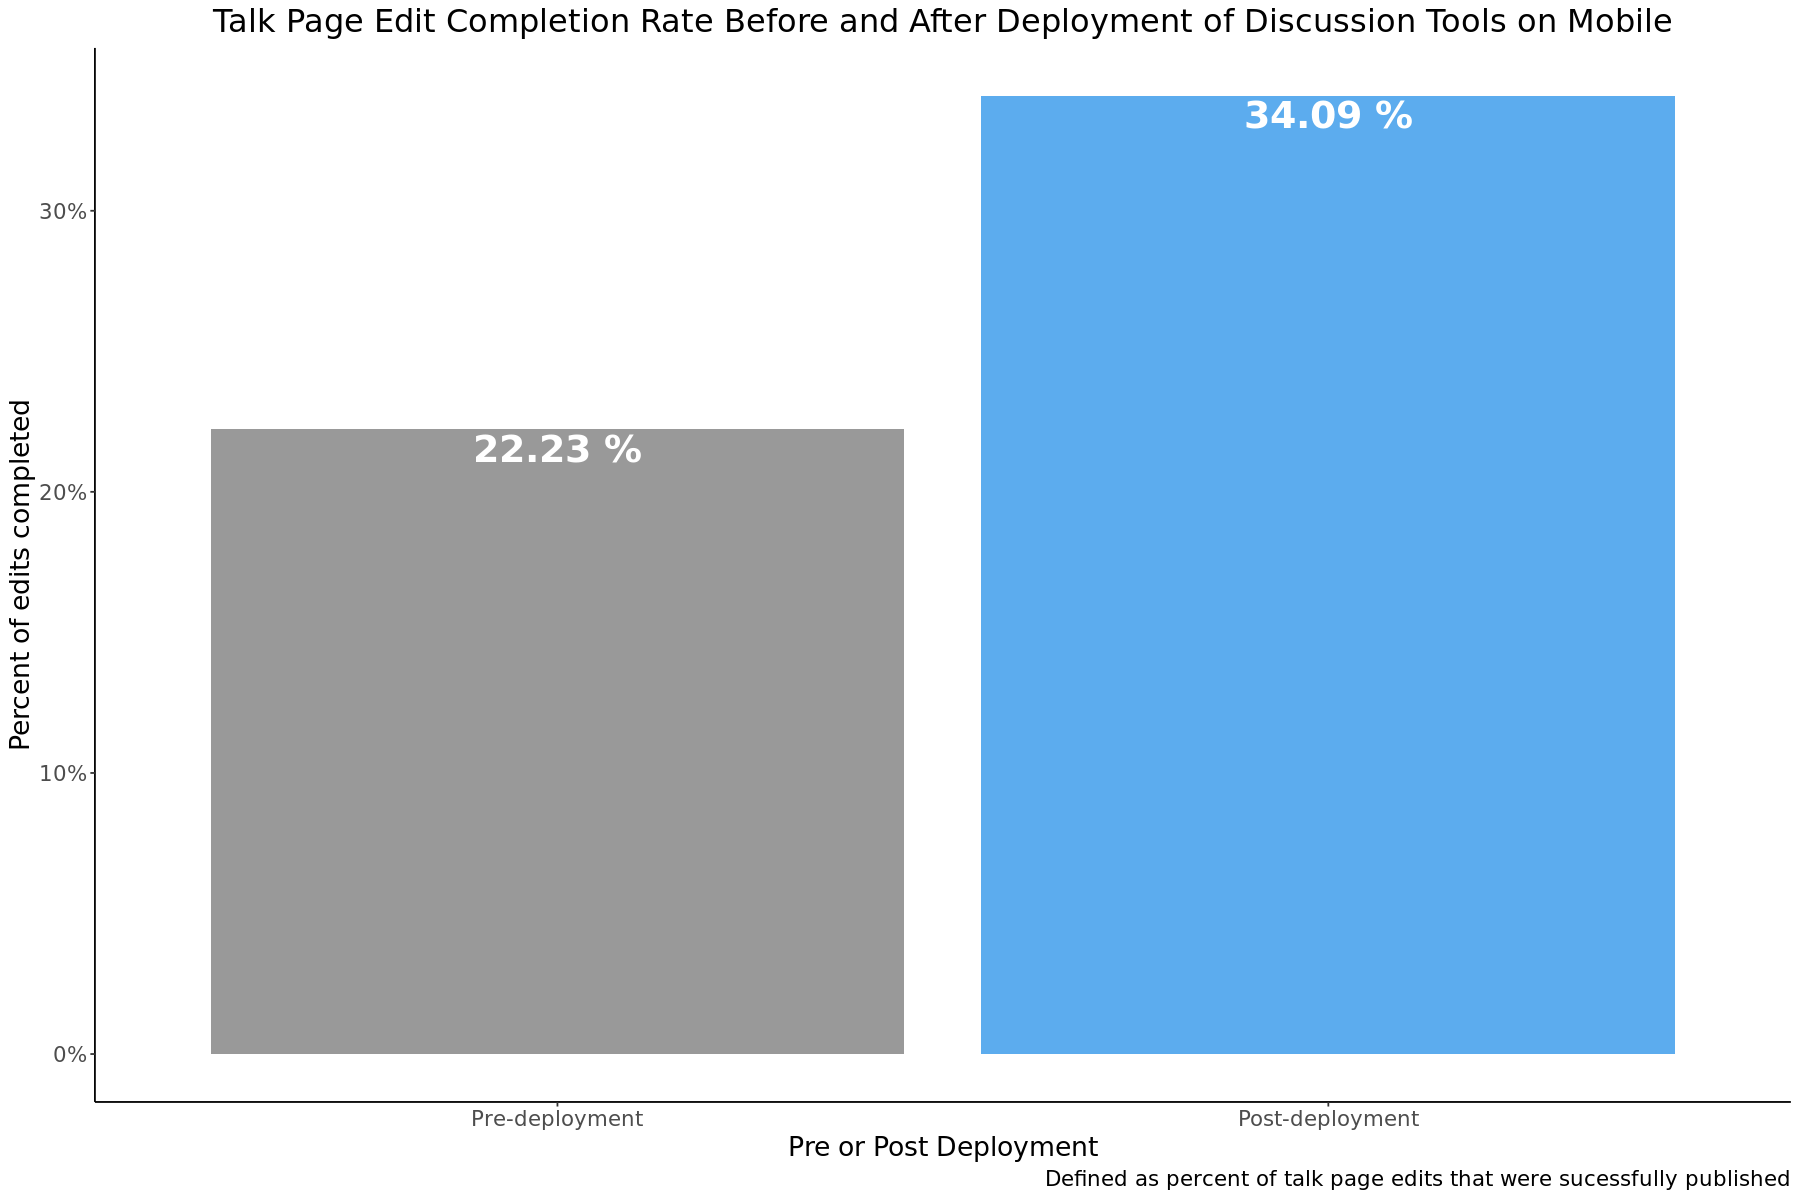

In [20]:
# plot edit completion rate overall

p <- edit_completes_overall_combined  %>%
    ggplot(aes(x= pre_post, y = pct_completed, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(pct_completed * 100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-deployment", "Post-deployment")) +
    labs (y = "Percent of edits completed",
          x = "Pre or Post Deployment",
          title = "Talk Page Edit Completion Rate Before and After Deployment of Discussion Tools on Mobile",
         caption = "Defined as percent of talk page edits that were sucessfully published")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_completes_overall_combined.png", p, width = 16, height = 8, units = "in", dpi = 300)

### By Anon

In [21]:
### plot edit completion rate by anon

is_anon = c("Logged-In", "Logged-In", "Logged-Out", "Logged-Out")
pre_post = c('post', 'pre', 'post', 'pre')
pct_completed <- c(0.4448, 0.2938, 0.1427, 0.04424)

edit_completes_overall_combined_byanon <- data.frame(is_anon,pre_post, pct_completed)

In [22]:
# set factor levels

edit_completes_overall_combined_byanon$pre_post <-
  factor(
    edit_completes_overall_combined_byanon$pre_post,
    levels = c('pre', 'post')
  )

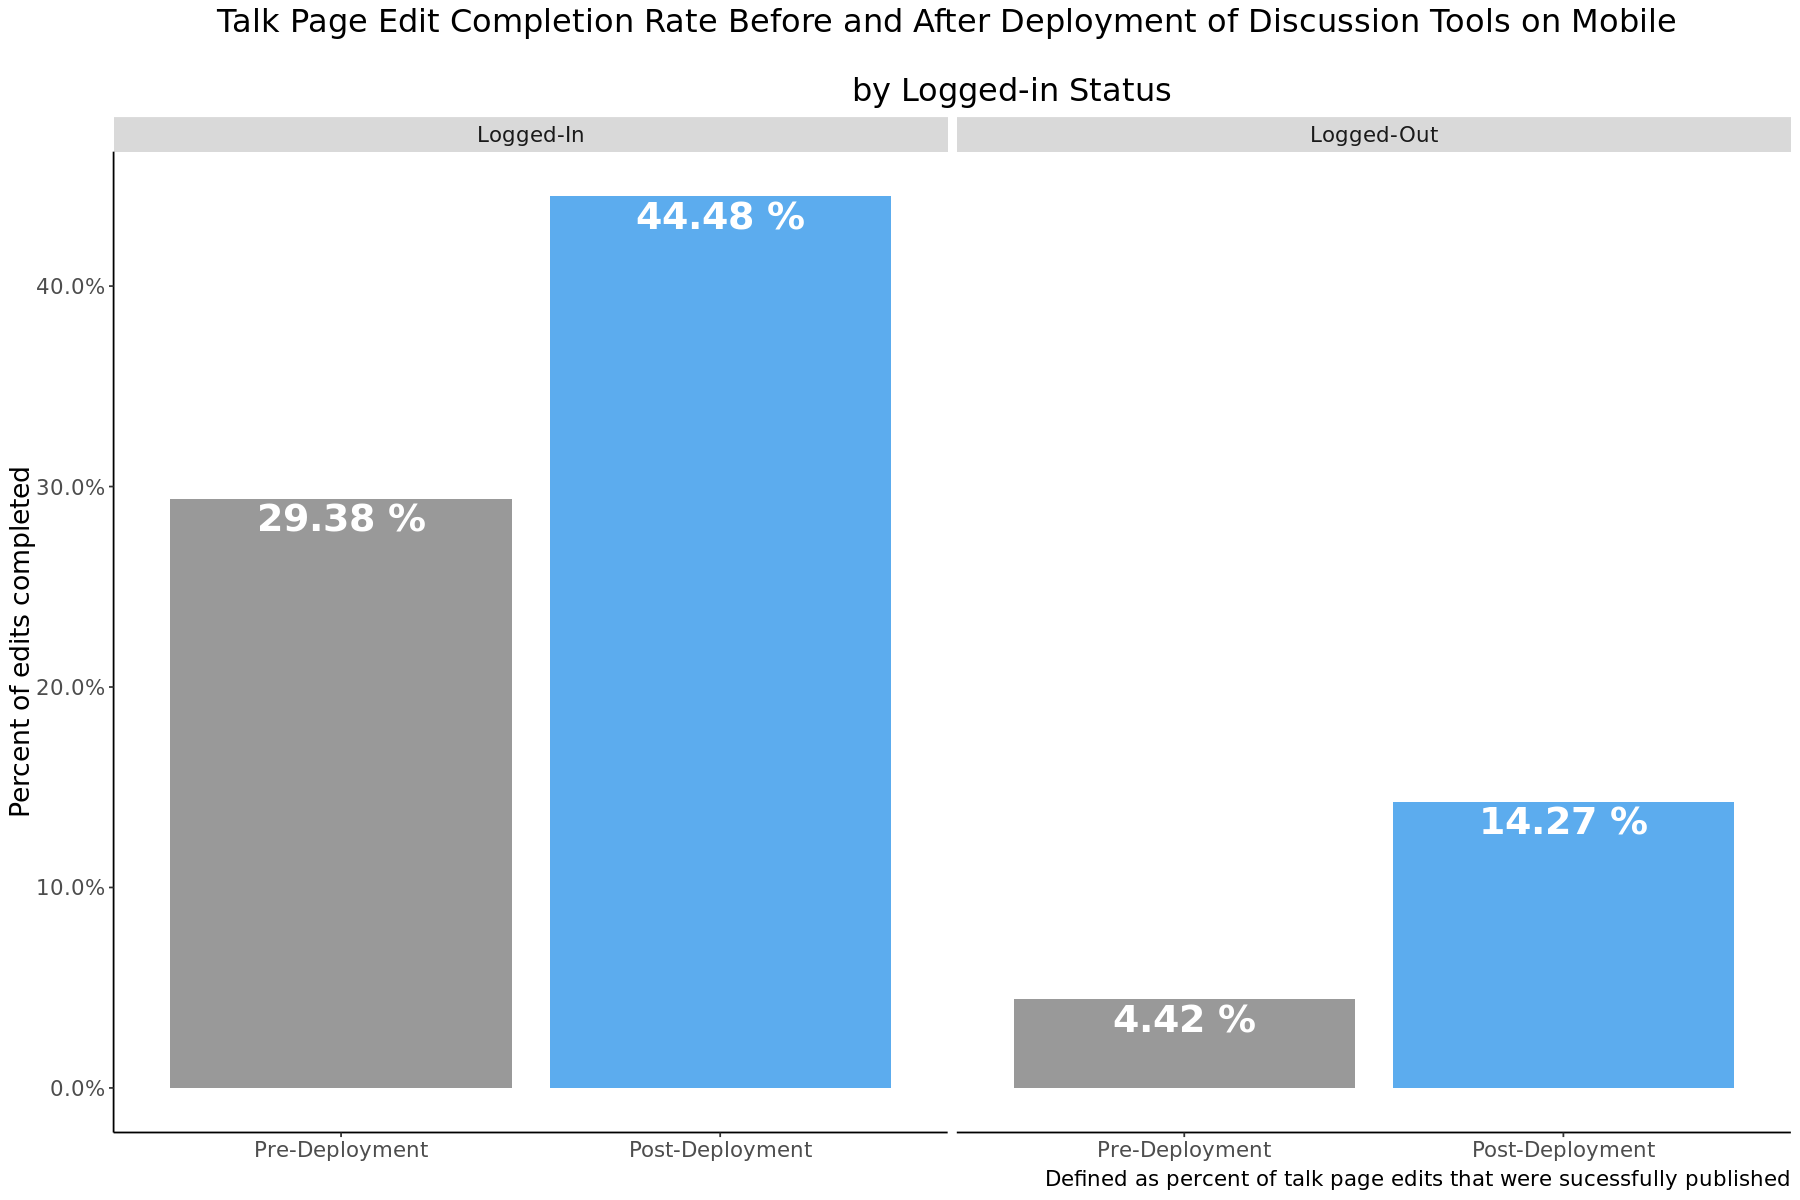

In [23]:
# plot edit completion rate by anon

p <- edit_completes_overall_combined_byanon  %>%
    ggplot(aes(x= pre_post, y = pct_completed, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(pct_completed * 100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_grid(~is_anon) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    labs (y = "Percent of edits completed",
          title = "Talk Page Edit Completion Rate Before and After Deployment of Discussion Tools on Mobile \n
            by Logged-in Status",
         caption = "Defined as percent of talk page edits that were sucessfully published")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_completes_overall_combined_byanon.png", p, width = 16, height = 8, units = "in", dpi = 300)

### By Experience Level

In [24]:
### create combined dataset that sums the post DT and Non DT edits
##FIXME: code this to avoid manual inputs

editor_experience = c('100-499','100-499', '500+', '500+', 'under 100', 'under 100')
pre_post = c('post', 'pre', 'post', 'pre', 'post', 'pre')
pct_completed <- c(0.49, 0.17, 0.52, 0.55, 0.23, 0.09)

edit_completes_overall_combined_byexp <- data.frame(editor_experience,pre_post, pct_completed)

In [25]:
# set factor levels

edit_completes_overall_combined_byexp$pre_post <-
  factor(
    edit_completes_overall_combined_byexp$pre_post,
    levels = c('pre', 'post')
  )

edit_completes_overall_combined_byexp$editor_experience <-
  factor(
    edit_completes_overall_combined_byexp$editor_experience,
    levels = c('under 100', '100-499', '500+')
  )

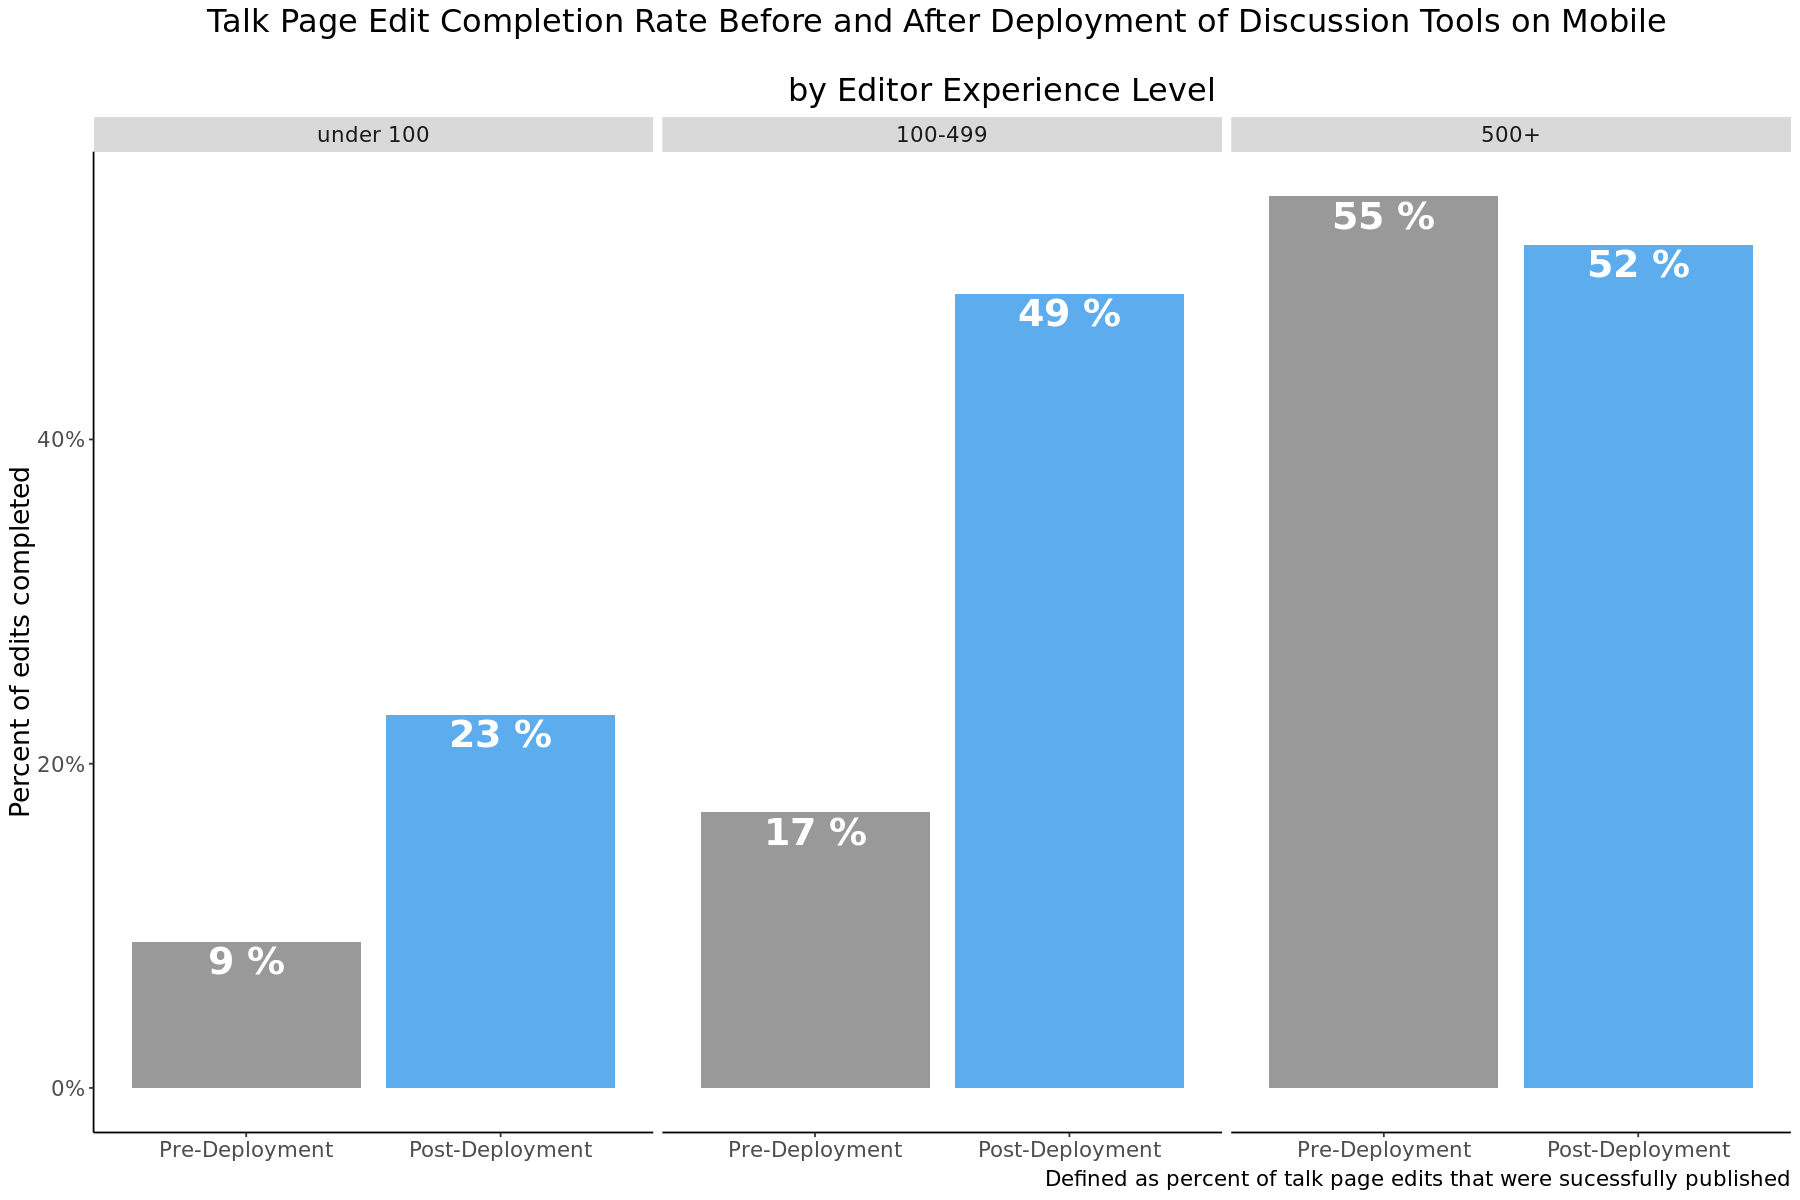

In [26]:
# plot edit completion rate by experience level

p <- edit_completes_overall_combined_byexp  %>%
    ggplot(aes(x= pre_post, y = pct_completed, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(pct_completed * 100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_grid(~editor_experience) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    labs (y = "Percent of edits completed",
          title = "Talk Page Edit Completion Rate Before and After Deployment of Discussion Tools on Mobile \n
            by Editor Experience Level",
         caption = "Defined as percent of talk page edits that were sucessfully published")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/edit_completes_overall_combined_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

# Talk Page Edit Revert Rate
## Peoples' likelihood to publish edits to talk pages on mobile that are disruptive to other volunteers.

For this analysis, disruption was calculated as the percent of talk page edits that are reverted within 48 hours of being published. Data comes from [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history)

In [21]:
query <- 

"
SELECT
    date_format(event_timestamp, 'yyyy-MM-dd') as `date`,
    wiki_db AS wiki,
    revision_id AS revision_id,
    event_user_is_anonymous AS is_anon,
    CASE
        WHEN event_user_revision_count is NULL THEN 'undefined'
        WHEN event_user_revision_count < 100 THEN 'under 100 edits'
        WHEN (event_user_revision_count >= 100 AND
        event_user_revision_count <= 500) THEN 'between 100 and 500 edits'
        ELSE 'over 500'
        END AS experience_level,
    IF(ARRAY_CONTAINS(revision_tags, 'discussiontools-newtopic') OR  
    ARRAY_CONTAINS(revision_tags, 'discussiontools-reply'), 'dt', 'no_dt') AS is_dt_edit,
    IF(revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800, 'reverted' , 'not-reverted'  -- 48 hours
           ) AS is_reverted
FROM wmf.mediawiki_history mwh
WHERE 
    snapshot = '2022-07'
     -- find all edits on talk pages
    AND page_namespace_historical % 2 = 1
    AND event_entity = 'revision'
    AND event_type = 'create'
    -- pre and pst deployment
    AND event_timestamp >= '2022-06-14' 
    AND event_timestamp <= '2022-07-13'
    -- on all participating wikis
    AND wiki_db IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
    -- user is not a bot
-- for bots size(event_user_is_bot_by) returns 1/2, IP editors return -1, registered non-bot editors return 0
    AND SIZE(event_user_is_bot_by_historical) <= 0 
    AND SIZE(event_user_is_bot_by) <= 0
-- only mobile web edits
    AND array_contains(revision_tags, 'mobile web edit')
"


In [22]:
revert_edits <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [23]:
#reformat and clean data
revert_edits$date <- as.Date(revert_edits $date, format = "%Y-%m-%d")


#clarfiy wiki names
revert_edits <- revert_edits  %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'arwiki' ~ "Arabic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'htwiki' ~ 'Haitian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 


### Overall

In [110]:
# determine revert data
reverts_pre_post_overall <- revert_edits %>%
    mutate(pre_post = factor(ifelse(date < '2022-06-29', 'pre', 'post'))) %>%
    group_by(pre_post) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =total_reverts/total_comments)

reverts_pre_post_overall 
           
        

`summarise()` ungrouping output (override with `.groups` argument)



pre_post total_reverts total_comments revert_rate
1 post     589           5725           0.1028821  
2 pre      622           5781           0.1075938

In [111]:
# set factor levels

reverts_pre_post_overall$pre_post <-
  factor(
    reverts_pre_post_overall$pre_post,
    levels = c('pre', 'post')
  )


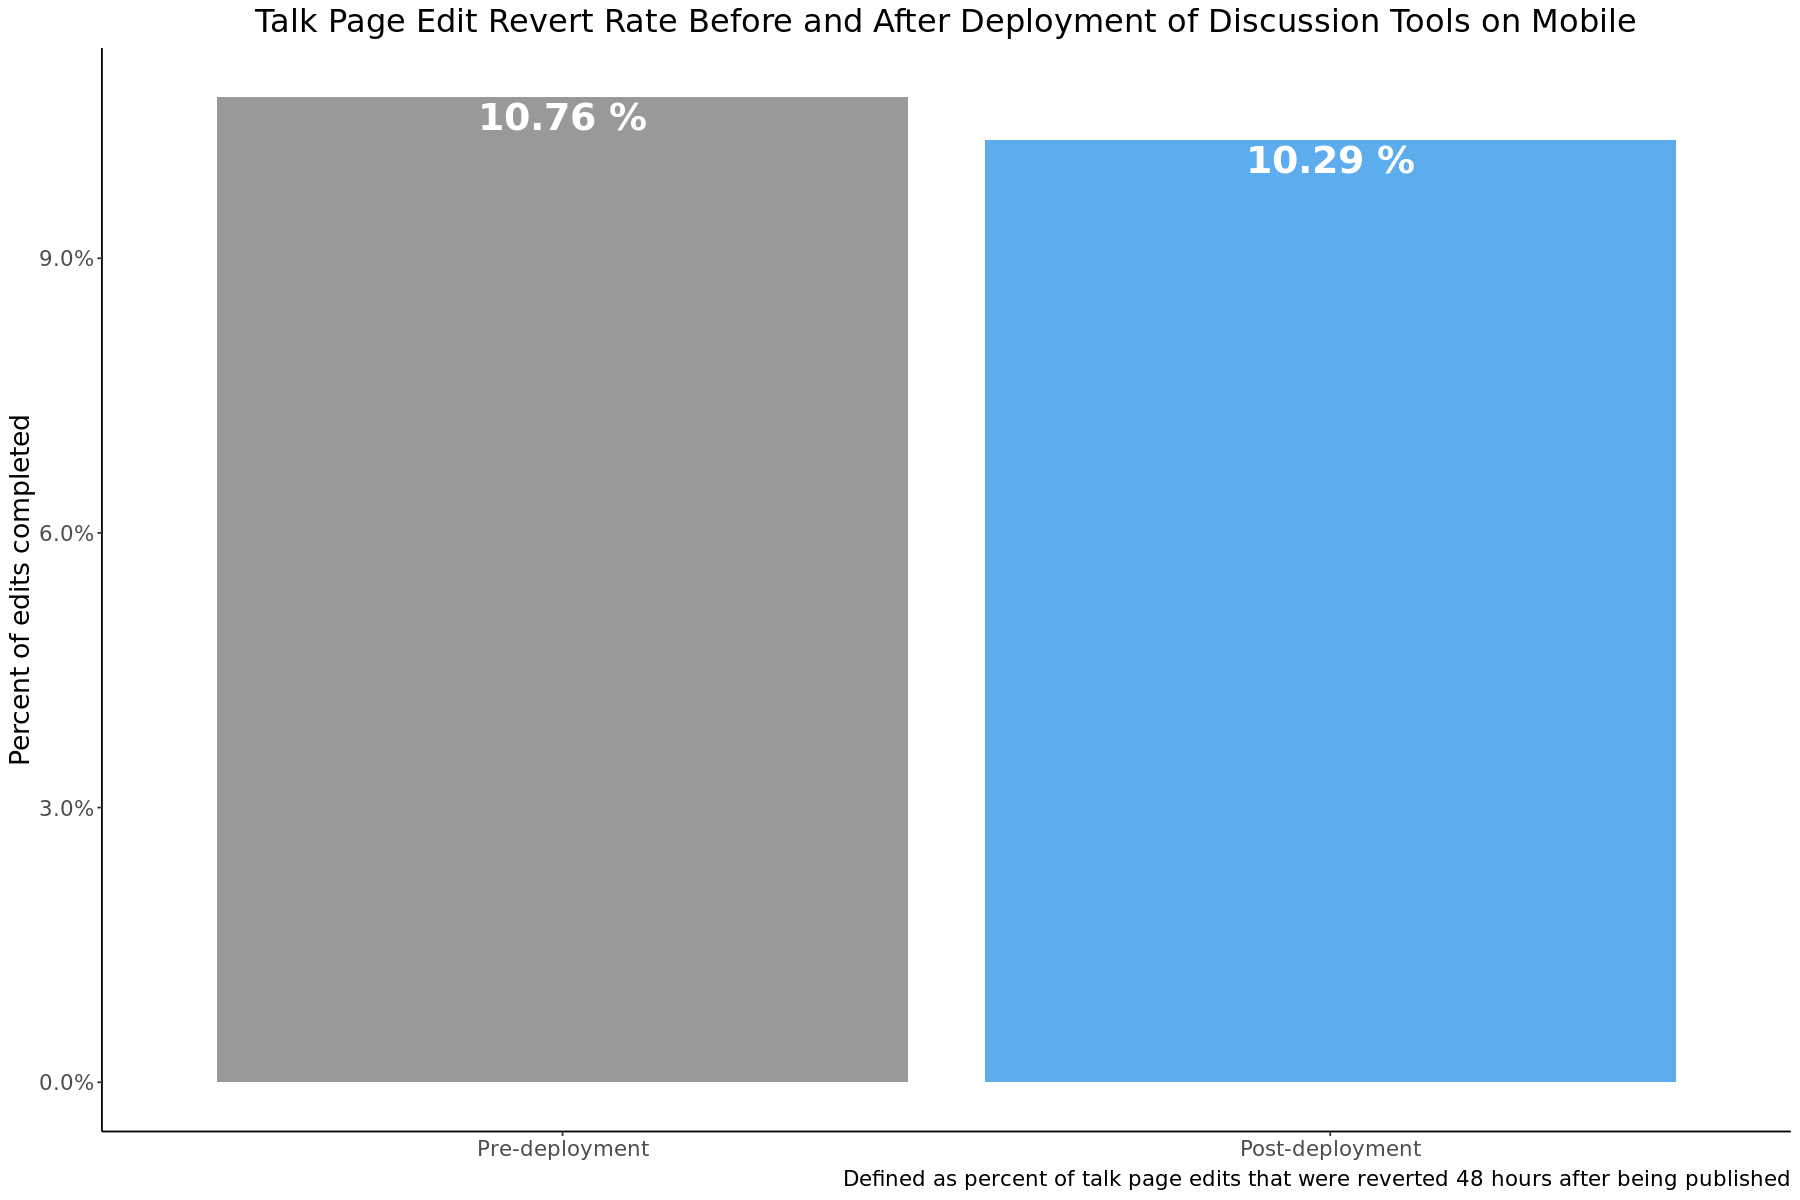

In [139]:
# plot values

p <- reverts_pre_post_overall  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(revert_rate * 100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-deployment", "Post-deployment")) +
    labs (y = "Percent of edits completed",
          x = "Pre or Post Deployment",
          title = "Talk Page Edit Revert Rate Before and After Deployment of Discussion Tools on Mobile",
         caption = "Defined as percent of talk page edits that were reverted 48 hours after being published")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/reverts_pre_post_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

`summarise()` regrouping output by 'date' (override with `.groups` argument)



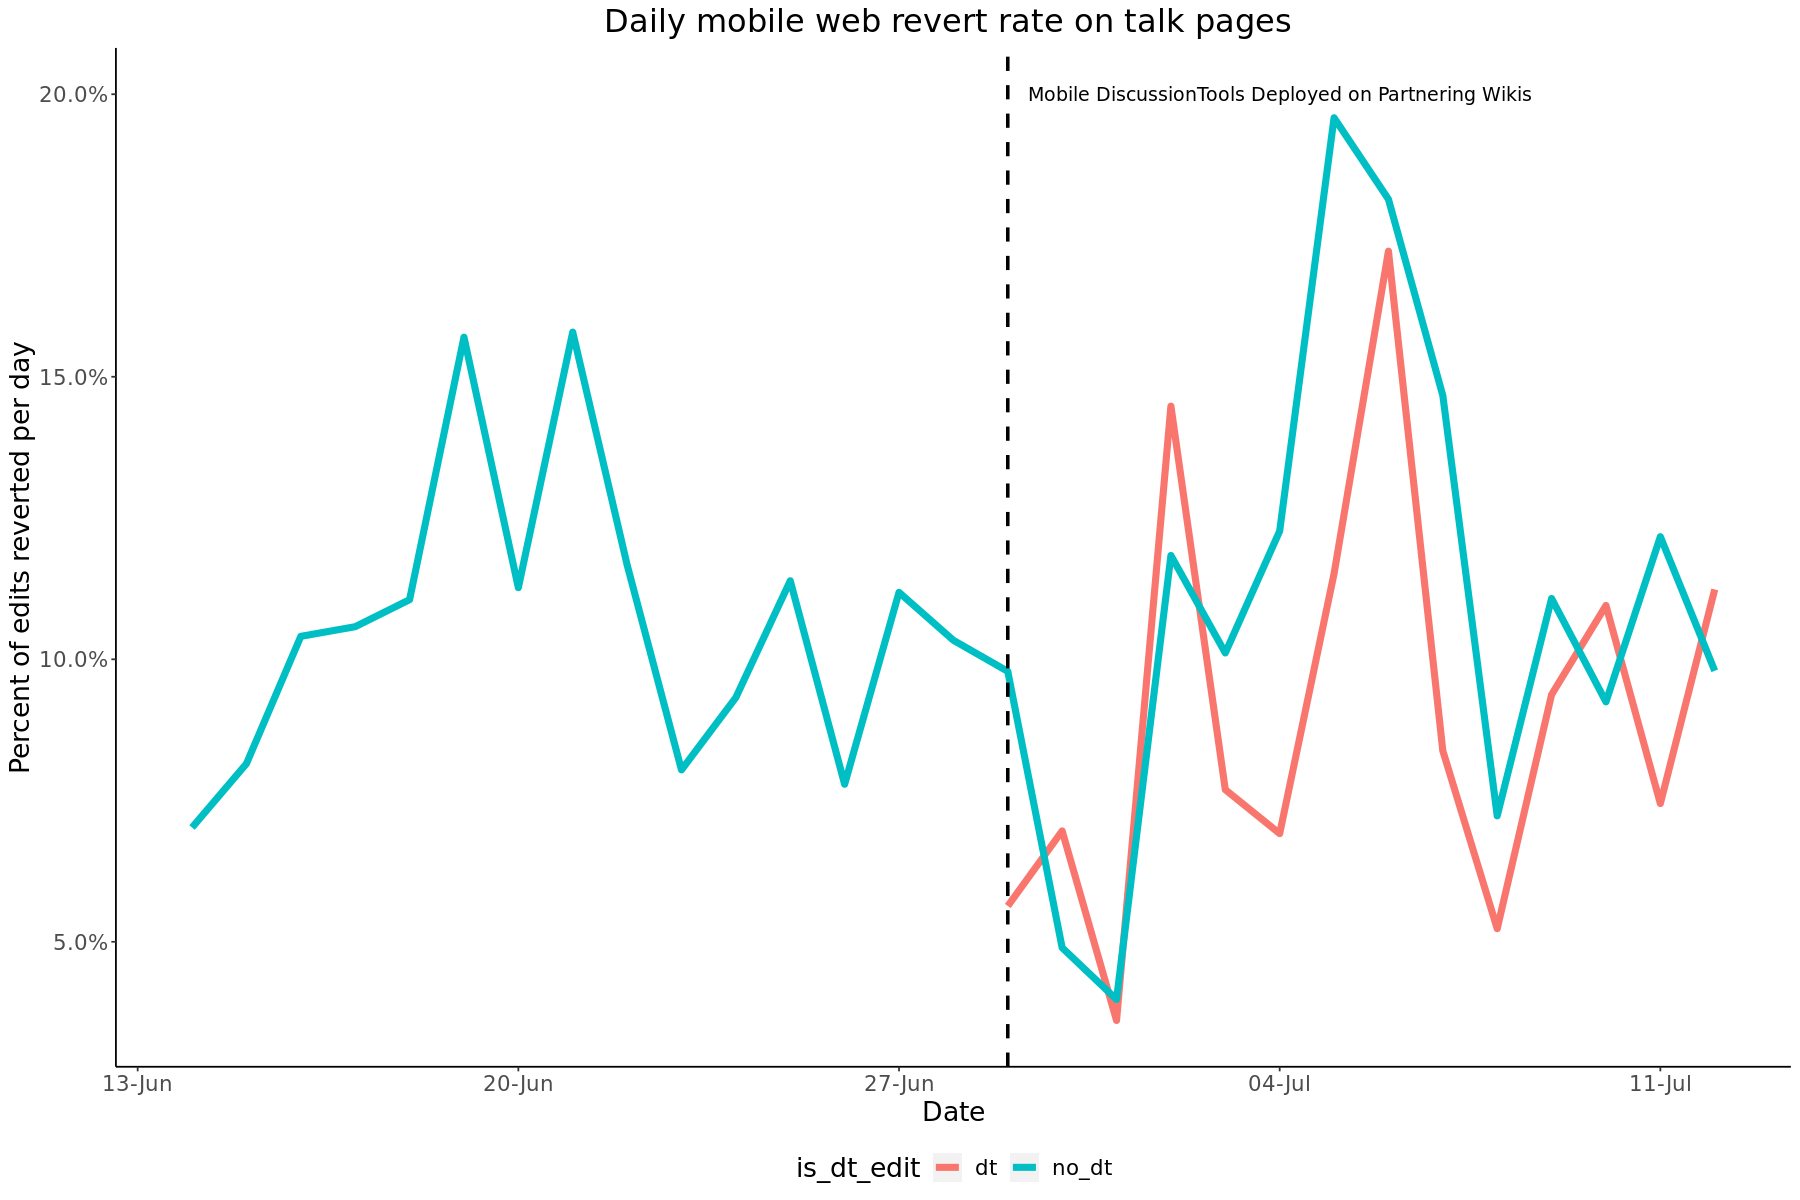

In [25]:
textaes <- data.frame(y = c(.20),
                      x = as.Date(c('2022-07-04')),
                      lab = c("Mobile DiscussionTools Deployed on Partnering Wikis"),
                     size = 30,
                      face = "bold"
                     )

 p <- revert_edits %>%
    group_by(date, is_dt_edit) %>%
     summarise(total_reverts = n_distinct(revision_id[is_reverted == "reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate = total_reverts/total_comments) %>%
    ggplot(aes(x= date, y = revert_rate, color = is_dt_edit)) +
    geom_line(size = 2) +
    geom_vline(xintercept = as.Date('2022-06-29'), linetype = 'dashed', size = 1) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of edits reverted per day",
          x = "Date",
         title = "Daily mobile web revert rate on talk pages ") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black"))    

p

#ggsave("Figures/revert_edits_daily.png", p, width = 16, height = 11, units = "in", dpi = 300)

## By Anonymous

In [133]:
# determine revert data
reverts_pre_post_byanon <- revert_edits %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(is_anon, pre_post) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =total_reverts/total_comments)

reverts_pre_post_byanon

`summarise()` regrouping output by 'is_anon' (override with `.groups` argument)



is_anon pre_post total_reverts total_comments revert_rate
1 false   post     366           4966           0.07370117 
2 false   pre      398           5096           0.07810047 
3 true    post     223            759           0.29380764 
4 true    pre      224            685           0.32700730

In [134]:
# set factor levels

reverts_pre_post_byanon$pre_post <-
  factor(
    reverts_pre_post_byanon$pre_post,
    levels = c('pre', 'post')
  )

reverts_pre_post_byanon$is_anon <-
  factor(
    reverts_pre_post_byanon$is_anon,
    levels = c('false', 'true'),
    labels = c('Logged-In', 'Logged-Out')
  )



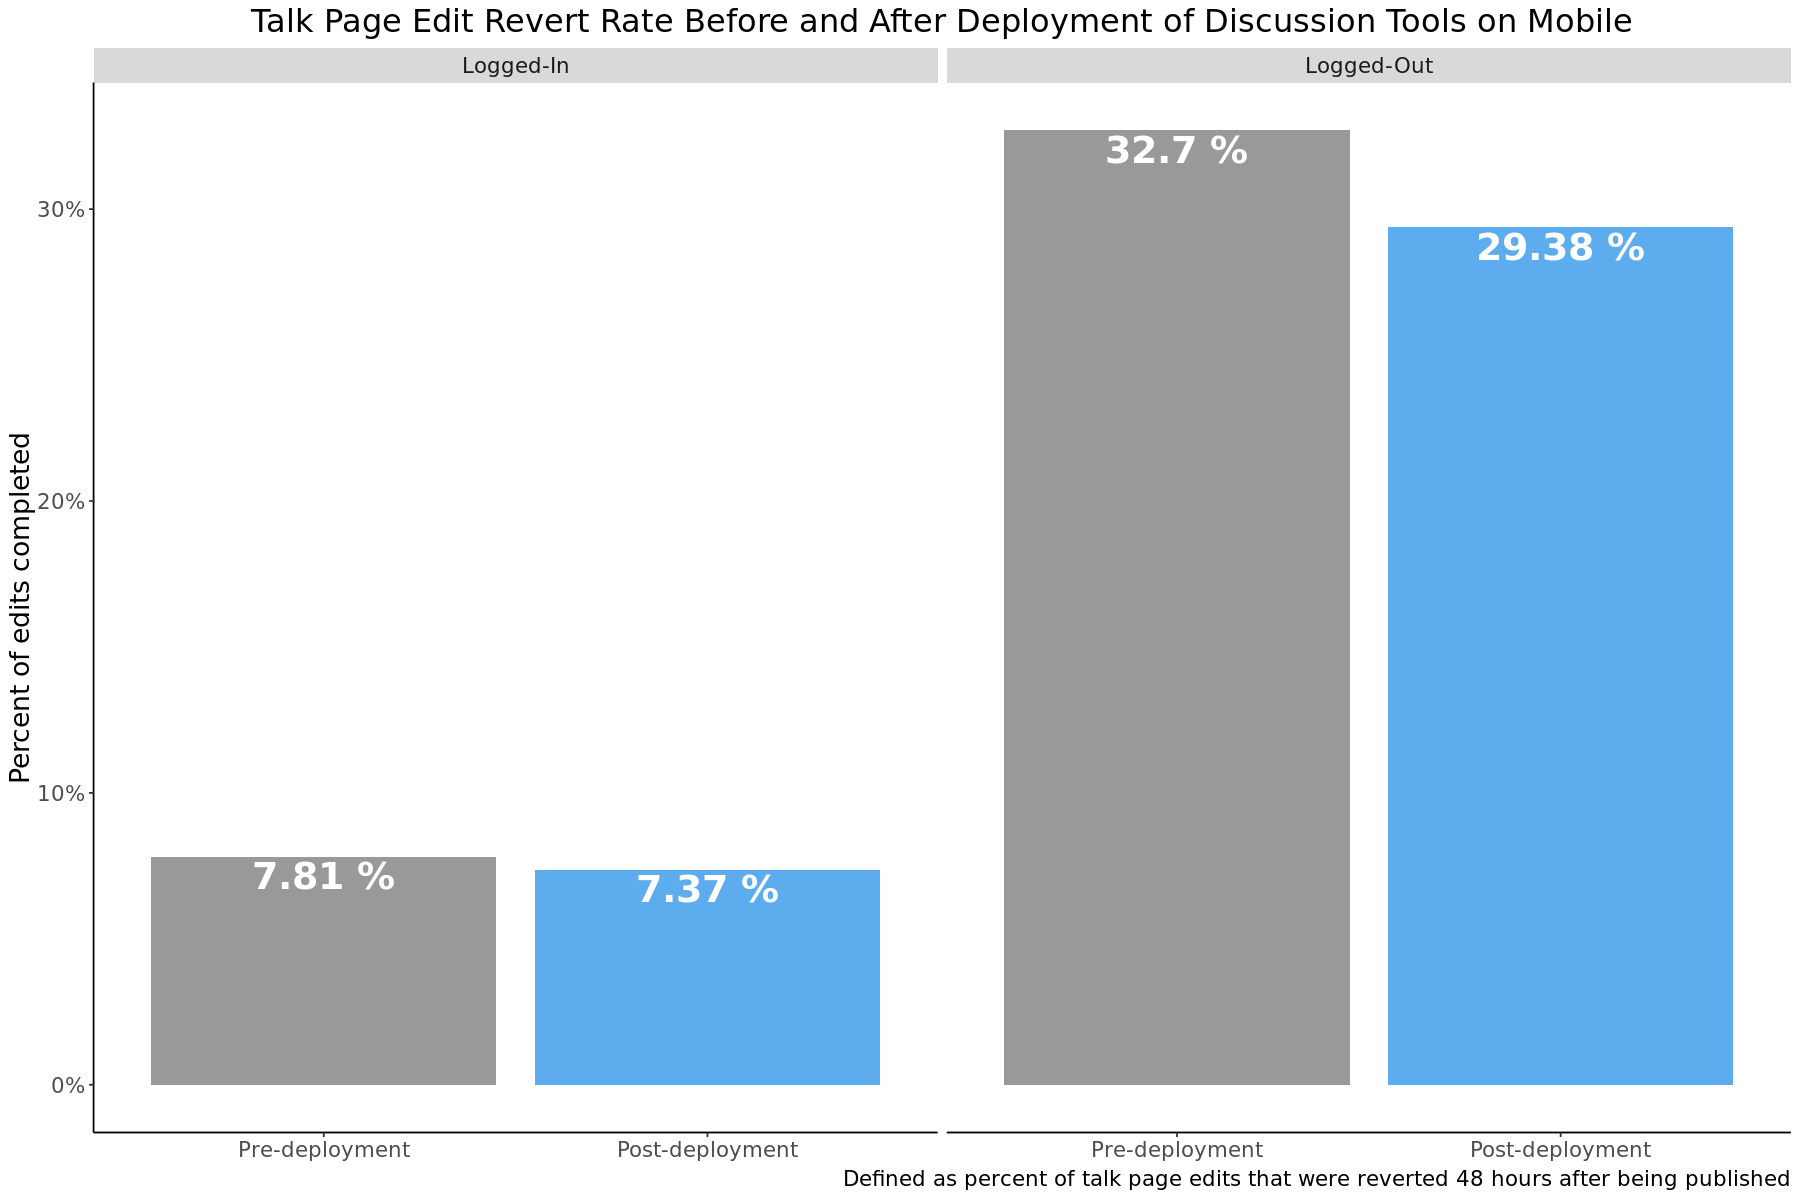

In [138]:
# plot values

p <- reverts_pre_post_byanon  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(round(revert_rate * 100, 2), "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_grid(~is_anon)  +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-deployment", "Post-deployment")) +
    labs (y = "Percent of edits completed",
          title = "Talk Page Edit Revert Rate Before and After Deployment of Discussion Tools on Mobile",
         caption = "Defined as percent of talk page edits that were reverted 48 hours after being published")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        axis.title.x=element_blank(),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/reverts_pre_post_byanon.png", p, width = 16, height = 8, units = "in", dpi = 300)

## By Experience Level

In [28]:
# determine revert data
reverts_pre_post_byexp <- revert_edits %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(experience_level, pre_post) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =paste(round(total_reverts/total_comments * 100, 2), '%'))

reverts_pre_post_byexp

`summarise()` regrouping output by 'experience_level' (override with `.groups` argument)



experience_level          pre_post total_reverts total_comments revert_rate
1 between 100 and 500 edits post      16            401           3.99 %     
2 between 100 and 500 edits pre       36            351           10.26 %    
3 over 500                  post     105           3077           3.41 %     
4 over 500                  pre       96           3000           3.2 %      
5 undefined                 post     223            759           29.38 %    
6 undefined                 pre      224            685           32.7 %     
7 under 100 edits           post     245           1488           16.47 %    
8 under 100 edits           pre      266           1745           15.24 %

## By Wiki

In [29]:
# determine revert data
reverts_pre_post_bywiki <- revert_edits %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(wiki, pre_post) %>%
    summarise(total_reverts = n_distinct(revision_id[is_reverted == "reverted"]),
              total_comments = n_distinct(revision_id),
              revert_rate =paste(round(total_reverts/total_comments * 100, 2), '%'))

reverts_pre_post_bywiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki                 pre_post total_reverts total_comments revert_rate
1  Arabic Wikipedia     post      87            869           10.01 %    
2  Arabic Wikipedia     pre      174           1071           16.25 %    
3  Bengali Wikipedia    post      68            994           6.84 %     
4  Bengali Wikipedia    pre       54            982           5.5 %      
5  Chinese Wikipedia    post      51            553           9.22 %     
6  Chinese Wikipedia    pre       38            516           7.36 %     
7  French Wikipedia     post      93            825           11.27 %    
8  French Wikipedia     pre       82            954           8.6 %      
9  Haitian Wikipedia    post       0              2           0 %        
10 Hebrew Wikipedia     post      21            728           2.88 %     
11 Hebrew Wikipedia     pre       35            750           4.67 %     
12 Japanese Wikipedia   post     196            832           23.56 %    
13 Japanese Wikipedia   pre      148            682           21.7 %     
14 Korean Wikipedia     post       9            177           5.08 %     
15 Korean Wikipedia     pre       29            205           14.15 %    
16 Vietnamese Wikipedia post      64            745           8.59 %     
17 Vietnamese Wikipedia pre       62            621           9.98 %

# Talk Page Engagement: Percent of talk page views where the users engages on the page by either clicking the add a topic button or section heading

Notes:
* Click tracking was also applied to readAsWiki page in [T295490](https://phabricator.wikimedia.org/T295490) so we are able to do a pre and post deployment comparison of clicks on the mobile site. 
* Currently there are only two types of events logged on talk pages (`talkpage.section` and `talkpage.add-topic`) pending resolution of [T302108](https://phabricator.wikimedia.org/T302108). 

In [141]:
query <-
"
WITH add_new_topic_clicks AS (
SELECT 
    DISTINCT event.token AS session
FROM event.mobilewebuiactionstracking
WHERE 
    -- two weeks prior and post deployments
    Year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
    AND (event.name = 'talkpage.add-topic' OR event.name = 'talkpage.section')
    AND event.action = 'click'
    AND useragent.is_bot = FALSE
    AND event.pageNamespace % 2 == 1 --only talk pages
    AND wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
)

--Talk page views
SELECT
date_format(mwui.dt, 'yyyy-MM-dd') AS `date`,
mwui.wiki AS wiki,
mwui.event.token AS session,
mwui.event.isAnon AS is_anon,
IF(add_new_topic_clicks.session IS NULL, 0, 1) AS new_topic_click
FROM
event.mobilewebuiactionstracking mwui
LEFT JOIN add_new_topic_clicks ON
    mwui.event.token = add_new_topic_clicks.session
WHERE 
    Year = 2022
    AND ((month = 06 and day >= 14) OR (month = 07 and day <= 13))
-- remove bots
AND useragent.is_bot = false 
--talk page view sessions
AND event.action = 'init'
AND event.name = 'ns=1'
AND wiki IN ('jawiki', 'arwiki', 'frwiki', 'kowiki', 'viwiki', 'hewiki', 'bnwiki', 'zhwiki', 'htwiki')
"

In [142]:
talk_page_clicks <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [143]:
#reformat and clean data
talk_page_clicks$date <- as.Date(talk_page_clicks$date, format = "%Y-%m-%d")


#clarfiy wiki names
talk_page_clicks <- talk_page_clicks %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'arwiki' ~ "Arabic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'htwiki' ~ 'Haitian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  )

## Overall

In [144]:
## new topic clicks pre and post

talk_page_engage <- talk_page_clicks%>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(pre_post) %>%
    summarise(n_views = n_distinct(session),
             n_clicks = n_distinct(session[new_topic_click==1]),
             pct_clicks = paste0(round(n_clicks/n_views * 100, 2), "%"))
              
talk_page_engage

`summarise()` ungrouping output (override with `.groups` argument)



pre_post n_views n_clicks pct_clicks
1 post     12971   4497     34.67%    
2 pre       7004   2040     29.13%

In [145]:
## By Anon

In [146]:
## new topic clicks pre and post

talk_page_engage_byanon <- talk_page_clicks %>%
    mutate(pre_post = ifelse(date < '2022-06-29', 'pre', 'post')) %>%
    group_by(is_anon, pre_post) %>%
    summarise(n_views = n_distinct(session),
             n_clicks = n_distinct(session[new_topic_click==1]),
             pct_clicks = paste0(round(n_clicks/n_views * 100, 2), "%"))
              
talk_page_engage_byanon

`summarise()` regrouping output by 'is_anon' (override with `.groups` argument)



is_anon pre_post n_views n_clicks pct_clicks
1 false   post      2873   1282     44.62%    
2 false   pre       1672    713     42.64%    
3 true    post     10114   3229     31.93%    
4 true    pre       5337   1331     24.94%